In [5]:
# !pip install -r requirements.txt
import torch 
import torch.nn as nn 
from torchvision import transforms
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt 
from PIL import Image
import cv2 as cv

from model.losses import soft_dice_loss, dice_coefficient, single_class_dice_coefficient
from training.dataloader import BraTSDataLoader, MRIDataLoader

from util.summarize_model import summarize_model
from model.unet import UNet2D
from torchsummary import summary
from tqdm import tqdm 
import random 

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# from util.data_helper import train_valid_split
# from pathlib import Path

# data_dir = Path("data/mri_data/all_data")
# train_valid_split(data_dir, valid_size=0.15, train_size=0.85, random_sampling=True)

In [4]:
import os 
import random 

class DataLoader(torch.utils.data.Dataset):

    def __init__(self, data_dir, subset="train"):
        assert subset in ["train", "valid"]
        
        self.data_dir = os.path.join(data_dir, subset)
        for data in os.walk(self.data_dir):
            self.patients = data[1]
            break
    
    
    def _readimage(self, idx, standardize=True):        
        image = os.path.join(self.data_dir, self.patients[idx], f"{self.patients[idx]}.tif")
        mask = os.path.join(self.data_dir, self.patients[idx], f"{self.patients[idx]}_mask.tif")
        
        img = cv.imread(image, cv.IMREAD_COLOR)
        msk = cv.imread(mask, cv.IMREAD_GRAYSCALE)
        
        img_tensor = torch.from_numpy(img).type(torch.FloatTensor)    
        msk_tensor = torch.from_numpy(msk).type(torch.FloatTensor) 

        img_tensor = torch.permute(img_tensor, (2,0,1))
        msk_tensor = msk_tensor.unsqueeze(0)
        
        return self._adjust(img_tensor, msk_tensor)


    def __getitem__(self, idx):
        image, mask = self._readimage(idx)
        return {
            "image" : image,
            "mask" : mask 
        }

    
    def __len__(self):
        return len(self.patients)

    
    def _adjust(self, image, mask):
        image = image / 255
        mask = mask / 255 
        mask[mask > 0.5] = 1.0
        mask[mask <= 0.5] = 0.0
        return image, mask  
        
                             
    def print_patient_ids(self):
        print(self.patients)

In [5]:
data_dir = "data/mri_data/"
train_loader = DataLoader(data_dir, subset="train")
print(len(train_loader))

train_data = next(iter(train_loader))

image = train_data["image"]
mask  = train_data["mask"]

print("image size:", images.size())
print("mask size:", masks.size())

def showImage(image: torch.Tensor):
    import matplotlib.pyplot as plt 
    from matplotlib.pyplot import figure

    image = torch.permute(image, (1,2,0))
    image = image.cpu().detach().numpy()
    
    figure(figsize=(4, 4), dpi=80)
    plt.imshow(image, cmap="gray")

showImage(mask)
# showImage(image)

unet = UNet2D(3,1).cuda()

out = unet(image.unsqueeze(0).cuda())
out = (out > 0.5).float()

showImage(out.squeeze(0).cpu())

3340


NameError: name 'images' is not defined

In [2]:
# define the model
unet = UNet2D(in_ch=3, out_ch=1).to("cuda")
# summary(unet, input_size=(3, 572, 572))

In [6]:
def accuracy(model, loader):
    num_correct = 0.
    num_pixels = 0.
    dice_score = 0.
    accuracy_score = 0.
        
    model.eval()
    
    with torch.no_grad():
        for batch in loader:
            x = batch["image"].cuda()
            y = batch["mask"].cuda()
            
            preds = model(x)
            preds = (preds > 0.5).float()
            num_correct += (preds==y).sum()
            num_pixels += torch.numel(preds)
            accuracy_score = num_correct / num_pixels
            # dice_score += 2 * (preds * y).sum() / ((preds + y).sum() + 1e-8)      
            dice_score += single_class_dice_coefficient(preds, y, axis=(0,1,2,3))
        dice_score = dice_score / len(loader)

    return float(accuracy_score), float(dice_score)


def adjust(mask):
    mask[mask>0.5] = 1.
    mask[mask<=0.5] = 0.
    return mask
    
    
def train(model, train_loader, valid_loader, epochs):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    
    losses_vec, accuracies, dice_scores = [], [], []
    best_dice_score = 0.

    for epoch in range(epochs):
        total_loss = 0.
        model.train()
        for i, batch in enumerate(tqdm(train_loader)):
            batch["image"], batch["mask"] = batch["image"].cuda(), batch["mask"].cuda()
            optimizer.zero_grad()
            preds = model(batch["image"])
            batch_train_loss = criterion(preds, batch["mask"])
            # batch_train_loss = soft_dice_loss(preds, batch["mask"], axis=(1,2,3))

            batch_train_loss.backward()
            optimizer.step()
            
            total_loss += batch_train_loss.item()
        scheduler.step()
        
        losses_vec.append(total_loss)
        acc, dice_score = accuracy(model, valid_loader)
        accuracies.append(acc)
        dice_scores.append(dice_score)

        print(f"Epoch: {epoch+1}; Total batch loss:", total_loss / len(train_loader))
        print(f"Accuracy: {acc:.4f}")
        print(f"Dice score: {dice_score:.4f}")
        
        if dice_score > best_dice_score:
            # TODO save model
            print("Dice score increased.. Saving model..")
            torch.save(model.state_dict(), "runs/test2/model_best.ckpt")
            best_dice_score = dice_score

    print("Best dice score:", best_dice_score)
    
    plt.subplot(1,3,1)
    plt.plot(losses_vec)
    plt.subplot(1,3,2)
    plt.plot(accuracies)
    plt.subplot(1,3,3)
    plt.plot(dice_scores)
    plt.show()


train_dataset = MRIDataLoader(data_dir="data/mri_data/", subset="train")
train_dataloader = torch.utils.data.DataLoader(
        train_dataset,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=16,   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=4,   # Data is usually loaded in parallel by num_workers
        pin_memory= True  # This is an implementation detail to speed up data uploading to the GPU
    )

valid_dataset = MRIDataLoader(data_dir="data/mri_data/", subset="valid")
valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=16,   # The size of batches is defined here
        shuffle=False,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=4,   # Data is usually loaded in parallel by num_workers
        pin_memory= True  # This is an implementation detail to speed up data uploading to the GPU
    )


In [4]:
train(unet, train_dataloader, valid_dataloader, 75)

100%|██████████| 209/209 [02:04<00:00,  1.68it/s]


Epoch: 1; Total batch loss: 0.7362401898968163
Accuracy: 0.7072
Dice score: 0.0083
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 2; Total batch loss: 0.6969638050458078
Accuracy: 0.9901
Dice score: 0.0857
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 3; Total batch loss: 0.6941918619511801
Accuracy: 0.9911
Dice score: 0.4399
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 4; Total batch loss: 0.6936499812956632
Accuracy: 0.9916
Dice score: 0.4922
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 5; Total batch loss: 0.6930811396626194
Accuracy: 0.9922
Dice score: 0.3994


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 6; Total batch loss: 0.6925978771807474
Accuracy: 0.9935
Dice score: 0.5631
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 7; Total batch loss: 0.6921193787926122
Accuracy: 0.9942
Dice score: 0.6631
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 8; Total batch loss: 0.6919285384091464
Accuracy: 0.9936
Dice score: 0.5585


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 9; Total batch loss: 0.6917294982517735
Accuracy: 0.9941
Dice score: 0.6027


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 10; Total batch loss: 0.6916169738085076
Accuracy: 0.9938
Dice score: 0.5509


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 11; Total batch loss: 0.6915817280705465
Accuracy: 0.9943
Dice score: 0.6264


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 12; Total batch loss: 0.691555245641316
Accuracy: 0.9943
Dice score: 0.6161


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 13; Total batch loss: 0.6915067040749143
Accuracy: 0.9947
Dice score: 0.7089
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 14; Total batch loss: 0.6914047094053059
Accuracy: 0.9947
Dice score: 0.6659


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 15; Total batch loss: 0.6913649166029606
Accuracy: 0.9951
Dice score: 0.6936


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 16; Total batch loss: 0.6913059955578672
Accuracy: 0.9950
Dice score: 0.6862


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 17; Total batch loss: 0.6913773043874348
Accuracy: 0.9948
Dice score: 0.6646


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 18; Total batch loss: 0.6912163324903643
Accuracy: 0.9952
Dice score: 0.7036


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 19; Total batch loss: 0.6911695448405435
Accuracy: 0.9946
Dice score: 0.6395


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 20; Total batch loss: 0.6912027021344198
Accuracy: 0.9952
Dice score: 0.6995


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 21; Total batch loss: 0.691099714434318
Accuracy: 0.9955
Dice score: 0.7338
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 22; Total batch loss: 0.6910282881065989
Accuracy: 0.9957
Dice score: 0.7444
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 23; Total batch loss: 0.691073629844702
Accuracy: 0.9958
Dice score: 0.7541
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 24; Total batch loss: 0.6910120927546013
Accuracy: 0.9960
Dice score: 0.7652
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 25; Total batch loss: 0.6909552986542004
Accuracy: 0.9958
Dice score: 0.7420


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 26; Total batch loss: 0.6909199676445227
Accuracy: 0.9960
Dice score: 0.7609


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 28; Total batch loss: 0.6908442862866598
Accuracy: 0.9960
Dice score: 0.7576


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 29; Total batch loss: 0.6908295331389139
Accuracy: 0.9961
Dice score: 0.7647


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 30; Total batch loss: 0.6907944784780439
Accuracy: 0.9963
Dice score: 0.7819
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 31; Total batch loss: 0.6907924182677383
Accuracy: 0.9962
Dice score: 0.7818


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 32; Total batch loss: 0.6907563372091814
Accuracy: 0.9962
Dice score: 0.7758


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 33; Total batch loss: 0.6907424661531403
Accuracy: 0.9962
Dice score: 0.7735


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 34; Total batch loss: 0.6907346864636434
Accuracy: 0.9962
Dice score: 0.7736


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 35; Total batch loss: 0.6907293622573597
Accuracy: 0.9964
Dice score: 0.7945
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 36; Total batch loss: 0.690714453681234
Accuracy: 0.9964
Dice score: 0.7919


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 37; Total batch loss: 0.6907147839308926
Accuracy: 0.9963
Dice score: 0.7797


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 38; Total batch loss: 0.6906974560906443
Accuracy: 0.9964
Dice score: 0.7929


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 39; Total batch loss: 0.6906969304860494
Accuracy: 0.9963
Dice score: 0.7769


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 40; Total batch loss: 0.6906795689934179
Accuracy: 0.9965
Dice score: 0.7989
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 41; Total batch loss: 0.6906783920155758
Accuracy: 0.9964
Dice score: 0.7890


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 42; Total batch loss: 0.6906785177842282
Accuracy: 0.9965
Dice score: 0.8002
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 43; Total batch loss: 0.6906798630239861
Accuracy: 0.9965
Dice score: 0.7943


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 44; Total batch loss: 0.690661000578027
Accuracy: 0.9965
Dice score: 0.7951


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 45; Total batch loss: 0.6906369639355601
Accuracy: 0.9964
Dice score: 0.7920


100%|██████████| 209/209 [02:02<00:00,  1.71it/s]


Epoch: 46; Total batch loss: 0.6906573795245595
Accuracy: 0.9965
Dice score: 0.7987


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 47; Total batch loss: 0.6906408456524024
Accuracy: 0.9964
Dice score: 0.7860


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 48; Total batch loss: 0.6906443905602232
Accuracy: 0.9965
Dice score: 0.8002


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 49; Total batch loss: 0.6906403639670194
Accuracy: 0.9965
Dice score: 0.7966


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 50; Total batch loss: 0.6906461236579566
Accuracy: 0.9965
Dice score: 0.7968


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 51; Total batch loss: 0.6906629355900595
Accuracy: 0.9965
Dice score: 0.7973


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 52; Total batch loss: 0.6906422981234829
Accuracy: 0.9965
Dice score: 0.7987


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 53; Total batch loss: 0.6906262037286348
Accuracy: 0.9965
Dice score: 0.8012
Dice score increased.. Saving model..


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 54; Total batch loss: 0.6906501103246041
Accuracy: 0.9965
Dice score: 0.7928


100%|██████████| 209/209 [02:02<00:00,  1.71it/s]


Epoch: 55; Total batch loss: 0.6906393889034764
Accuracy: 0.9965
Dice score: 0.7939


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 56; Total batch loss: 0.690620373310655
Accuracy: 0.9965
Dice score: 0.7995


100%|██████████| 209/209 [02:02<00:00,  1.70it/s]


Epoch: 57; Total batch loss: 0.6906253840934717
Accuracy: 0.9964
Dice score: 0.7903


 64%|██████▎   | 133/209 [01:18<00:44,  1.71it/s]Exception in thread Thread-120:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.9/dist-packages/torch/multiprocessing/reductions.py", line 297, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.9/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.9/multiprocessing/reduction.py", line 189, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.9/multiprocessi

KeyboardInterrupt: 

In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="sum")

out = unet(images)
print(out.size())

loss_dice = soft_dice_loss(out.cpu(), masks.cpu())
loss_bce = criterion(out.cpu(), masks.cpu())

print("loss_dice:", loss_dice)
print("loss_bce:", loss_bce)

In [2]:
from inference.inference import UNet2DInference

ckpt_path = "runs/test2/model_best.ckpt"
unet_inference = UNet2DInference(ckpt_path)


valid len: 589
idx = 298
torch.Size([1, 256, 256])


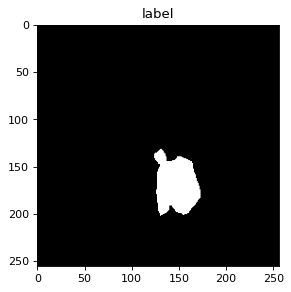

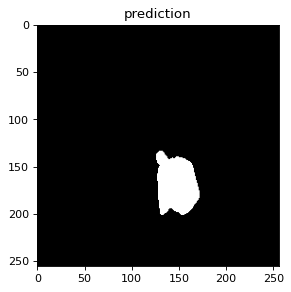

In [35]:
# test on validation image 
print("valid len:", len(valid_dataset))
idx = random.randint(0, len(valid_dataset))
print("idx =", idx)
valid_data = valid_dataset[idx]

image = valid_data["image"]
mask = valid_data["mask"]

prediction = unet_inference.inference(image)
print(prediction.size())


def showImage(image: torch.Tensor, title: str):
    import matplotlib.pyplot as plt 
    from matplotlib.pyplot import figure

    image = torch.permute(image, (1,2,0))
    image = image.cpu().detach().numpy()
    
    figure(figsize=(4, 4), dpi=80)
    plt.imshow(image, cmap="gray")
    plt.title(title)
    
showImage(mask, "label")
showImage(prediction, "prediction")


data index: 129


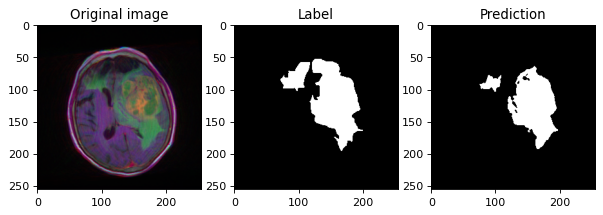

In [45]:
# unet_inference.plot_results(valid_dataset, indexes)
unet_inference.random_inference(valid_dataset)